In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
random_state = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18
...,...,...,...
19122,REITs vs. Stocks: What Does the Data Say?,2024-03-04,5130.95
19123,"Nasdaq Index, Dow Jones, S&P 500 News: Futures...",2024-03-04,5130.95
19124,"Nasdaq 100, Dow Jones, S&P 500 News: Cautious ...",2024-03-04,5130.95
19125,"Bank of America boosts S&P 500 target to 5,400...",2024-03-04,5130.95


In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

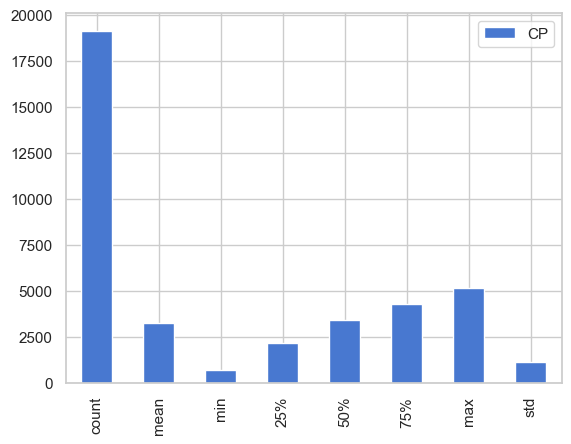

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

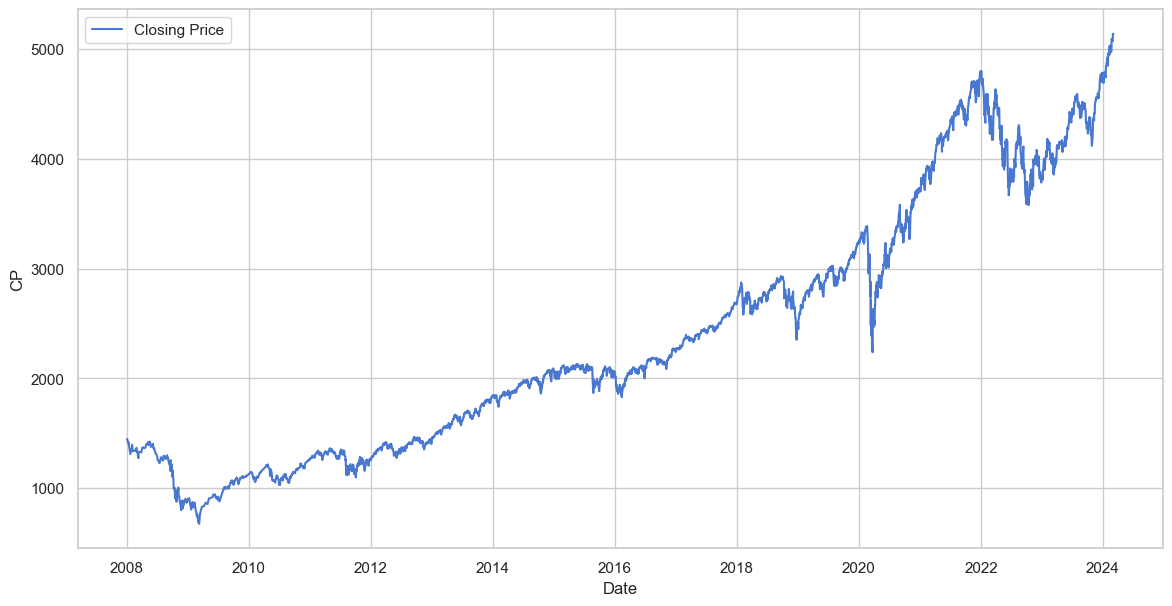

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


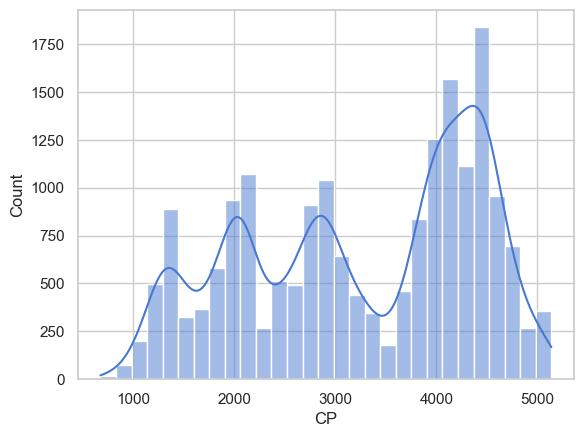

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)  # Limit to 1000 rows for testing
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [12:56<00:00, 24.64it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
# Define volatility period
volatility_period = [5, 22, 66, 126, 252]  # 5 days, 22 days (1 month), 66 days (3 months), 126 days (6 months)

# Daily average sentiment
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()

print(daily_sentiment)

           Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN            

## Prepare market data

In [151]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.8, close_col="CP"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Function to label crash events based on past close prices
def label_crash_event_day(df, look_back_days=252, drop_threshold=0.9, close_col="CP"):
    df = df.copy()
    df["past_close"] = df[close_col].shift(look_back_days)
    df["future_crash"] = (df[close_col] < df["past_close"] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
# Number of trading days in a year approximately 252 days
look_ahead_days = 252

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_test = add_future_crash_label(sp500_headlines_2008_2024_test, look_ahead_days, drop_threshold)
# sp500_headlines_2008_2024_test = label_crash_event_day(sp500_headlines_2008_2024_test, look_back_days=look_ahead_days, drop_threshold=drop_threshold)
sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash']]

,Date,CP,future_close,future_crash
0,2008-01-02,1447.16,1126.42,1
1,2008-01-02,1447.16,1126.42,1
2,2008-01-02,1447.16,1136.52,1
3,2008-01-03,1447.16,1136.52,1
4,2008-01-07,1416.18,1136.52,1
...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0
19123,2024-03-04,5130.95,NaN,0
19124,2024-03-04,5130.95,NaN,0
19125,2024-03-04,5130.95,NaN,0


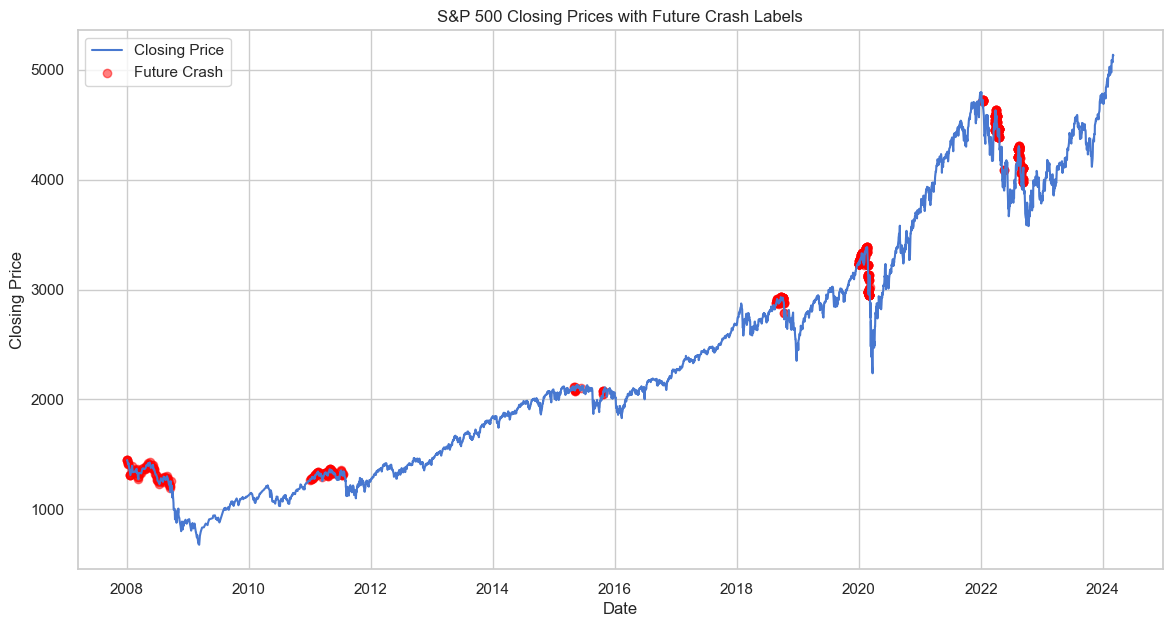

In [152]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024_test, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['CP'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [153]:
# Calculate daily returns
sp500_headlines_2008_2024_test['daily_return'] = sp500_headlines_2008_2024_test['CP'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_data = sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash', 'daily_return']].copy()
market_data['Date'] = pd.to_datetime(market_data['Date'])

market_data

,Date,CP,future_close,future_crash,daily_return
0,2008-01-02,1447.16,1126.42,1,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000
2,2008-01-02,1447.16,1136.52,1,0.000000
3,2008-01-03,1447.16,1136.52,1,0.000000
4,2008-01-07,1416.18,1136.52,1,-2.140745
...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000
19123,2024-03-04,5130.95,NaN,0,0.000000
19124,2024-03-04,5130.95,NaN,0,0.000000
19125,2024-03-04,5130.95,NaN,0,0.000000


In [154]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['CP'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_data = calculate_n_day_returns(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,126_day_market_return,252_day_market_return
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810


In [155]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(n)  # Standard deviation of closing prices
    return data

market_data = calculate_n_day_volatility(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,126_day_market_return,252_day_market_return,5_day_market_volatility,22_day_market_volatility,66_day_market_volatility,126_day_market_volatility,252_day_market_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,0.0,0.0,0.811438,0.990814,2.491513
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,0.0,0.0,0.811438,0.990814,2.491513
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,0.0,0.0,0.811438,0.990814,2.442810
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,0.0,0.0,0.811438,0.990814,2.442810


## Align market data with sentiment data

In [156]:
# Merge market data with daily sentiment
print(daily_sentiment.shape)
print(market_data.shape)
market_sentiment_data = market_data.merge(daily_sentiment, on='Date', how='left')
market_sentiment_data

(3507, 7)
(19127, 15)


,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,126_day_market_return,252_day_market_return,...,22_day_market_volatility,66_day_market_volatility,126_day_market_volatility,252_day_market_volatility,avg_sentiment_score_a_day,5_day_sentiment_volatility,22_day_sentiment_volatility,66_day_sentiment_volatility,126_day_sentiment_volatility,252_day_sentiment_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.787446,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.338189,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,...,0.0,0.811438,0.990814,2.491513,0.069991,0.199239,0.201547,0.194642,0.179861,0.171921
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,...,0.0,0.811438,0.990814,2.491513,0.069991,0.199239,0.201547,0.194642,0.179861,0.171921
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,...,0.0,0.811438,0.990814,2.442810,0.069991,0.199239,0.201547,0.194642,0.179861,0.171921
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,...,0.0,0.811438,0.990814,2.442810,0.069991,0.199239,0.201547,0.194642,0.179861,0.171921


In [157]:
# Clean up the merged data
# market_sentiment_data.dropna(inplace=True)
# market_sentiment_data.reset_index(drop=True, inplace=True)

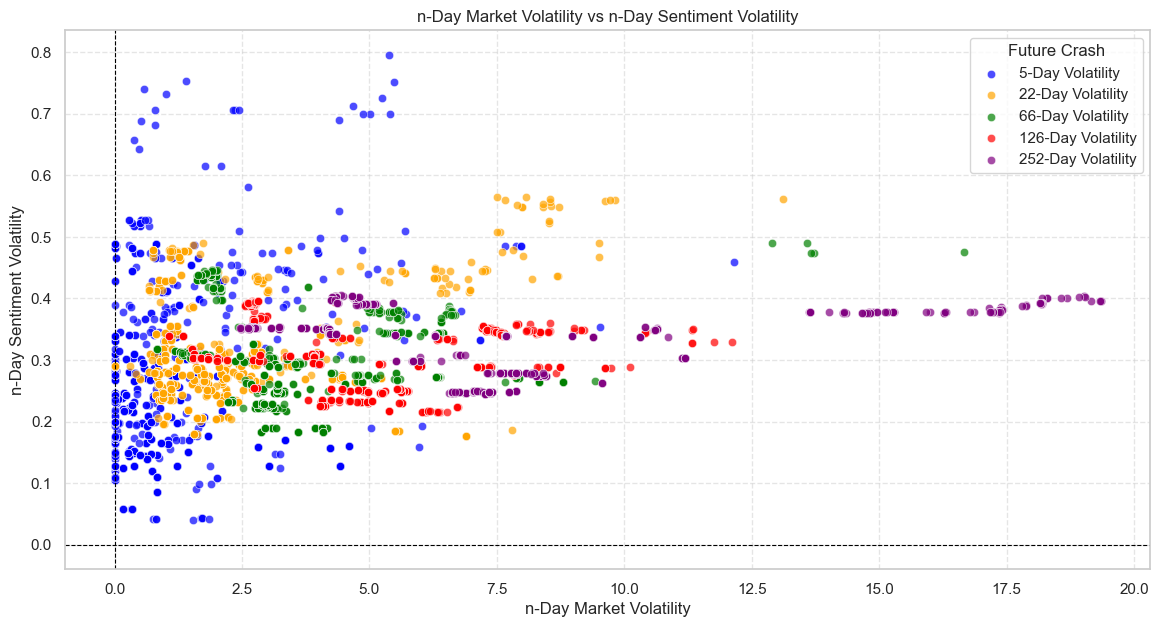

In [158]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

# for n in volatility_period:
#     crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(crash_data[f'{n}_day_market_volatility'])
    # crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(crash_data[f'{n}_day_sentiment_volatility'])

plt.figure(figsize=(14, 7))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='126_day_market_volatility', y='126_day_sentiment_volatility', data=crash_data, label='126-Day Volatility', alpha=0.7, color='red')
sns.scatterplot(x='252_day_market_volatility', y='252_day_sentiment_volatility', data=crash_data, label='252-Day Volatility', alpha=0.7, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='upper right')
plt.show()

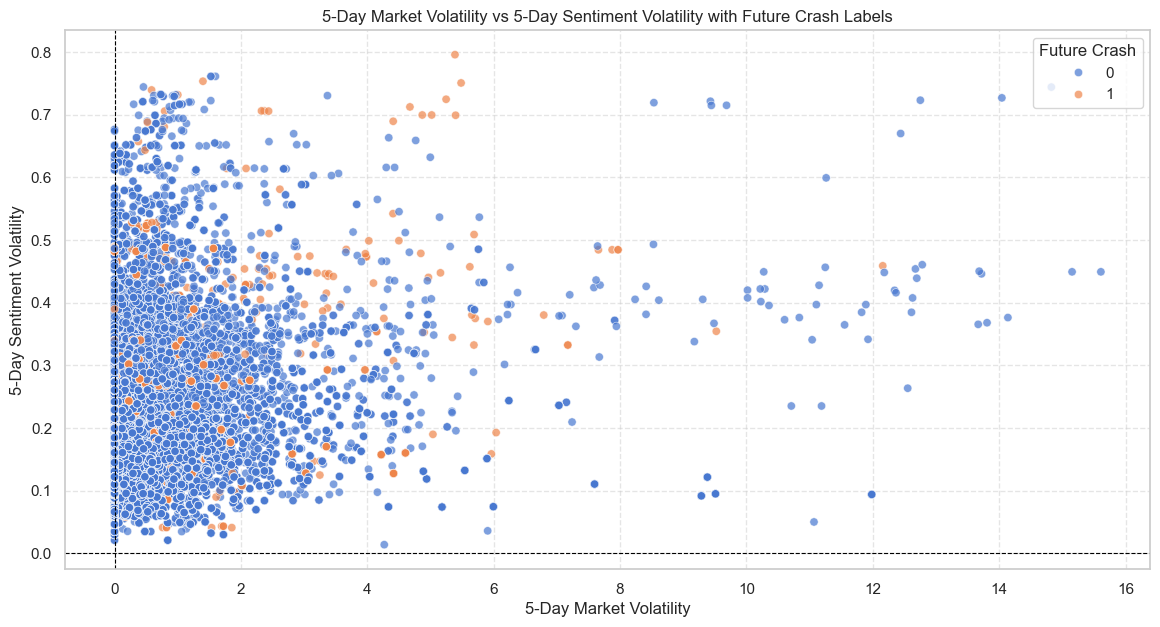

In [159]:
# Plot relationship between future crash and 5-day market volatility combined with sentiment volatility
plt.figure(figsize=(14, 7))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', hue='future_crash', data=market_sentiment_data, alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('5-Day Market Volatility vs 5-Day Sentiment Volatility with Future Crash Labels')
plt.xlabel('5-Day Market Volatility')
plt.ylabel('5-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='upper right')
plt.show()

## Modelling

In [242]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(np.percentile(np.random.normal(size=100000), confidence * 100))  # ≈1.64 for 95%, 1.96 for 97.5%

    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(market_sentiment_data, return_col='daily_return')

In [243]:
market_sentiment_data.columns

Index(['Date', 'CP', 'future_close', 'future_crash', 'daily_return',
       '5_day_market_return', '22_day_market_return', '66_day_market_return',
       '126_day_market_return', '252_day_market_return',
       '5_day_market_volatility', '22_day_market_volatility',
       '66_day_market_volatility', '126_day_market_volatility',
       '252_day_market_volatility', 'avg_sentiment_score_a_day',
       '5_day_sentiment_volatility', '22_day_sentiment_volatility',
       '66_day_sentiment_volatility', '126_day_sentiment_volatility',
       '252_day_sentiment_volatility', 'VaR_5', 'ES_5', 'VaR_22', 'ES_22',
       'VaR_66', 'ES_66', 'VaR_126', 'ES_126', 'VaR_252', 'ES_252'],
      dtype='object')

In [244]:
# Count future crash events
future_crash_counts = market_sentiment_data['future_crash'].value_counts()
print(future_crash_counts)

future_crash
0    18320
1      807
Name: count, dtype: int64


In [245]:
# Handle class imbalance
# Resample the data to balance classes
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=random_state)

# Prepare features and target variable
n = 5
target_col = 'future_crash'
feature_cols = [
    f'{n}_day_market_volatility',
    f'{n}_day_sentiment_volatility',
    f'VaR_{n}',
    f'ES_{n}',
]

X = market_sentiment_data[feature_cols].dropna()
y = market_sentiment_data.loc[X.index, target_col]

X = X.fillna(0)  # Fill NaN values with 0
X = X.fillna(X.mean())  # Fill NaN values with column means
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state) 
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_resampled.shape, y_resampled.shape)

Class distribution after resampling:
future_crash
0    14656
1    14656
Name: count, dtype: int64
(19120, 4) (19120,)
(15296, 4) (3824, 4) (15296,) (3824,)
(29312, 4) (29312,)


### Define plotting function

In [246]:
def plot_feature_importances(model, X):
    importances = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Crash', 'Crash'], yticklabels=['No Crash', 'Crash'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_crash_probabilities(df, target_col='crash_probability'):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df[target_col], label='Crash Probability', color='red')
    plt.axhline(0.5, linestyle='--', color='gray', label='Threshold = 0.5')  # Example threshold
    plt.title("Early Warning Signal: Crash Probability Over Time")
    plt.xlabel("Date")
    plt.ylabel("Predicted Crash Probability")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

### RandomForest

In [247]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_resampled, y_resampled)

print("Best params:", grid.best_params_)
print("Best AUC on CV:", grid.best_score_)

# Reuse best model
rf_model = grid.best_estimator_

# Predict
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Best Model ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9862216553516777
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3664
           1       0.55      0.75      0.63       160

    accuracy                           0.96      3824
   macro avg       0.77      0.86      0.81      3824
weighted avg       0.97      0.96      0.97      3824

Best Model ROC AUC: 0.9359434702510917


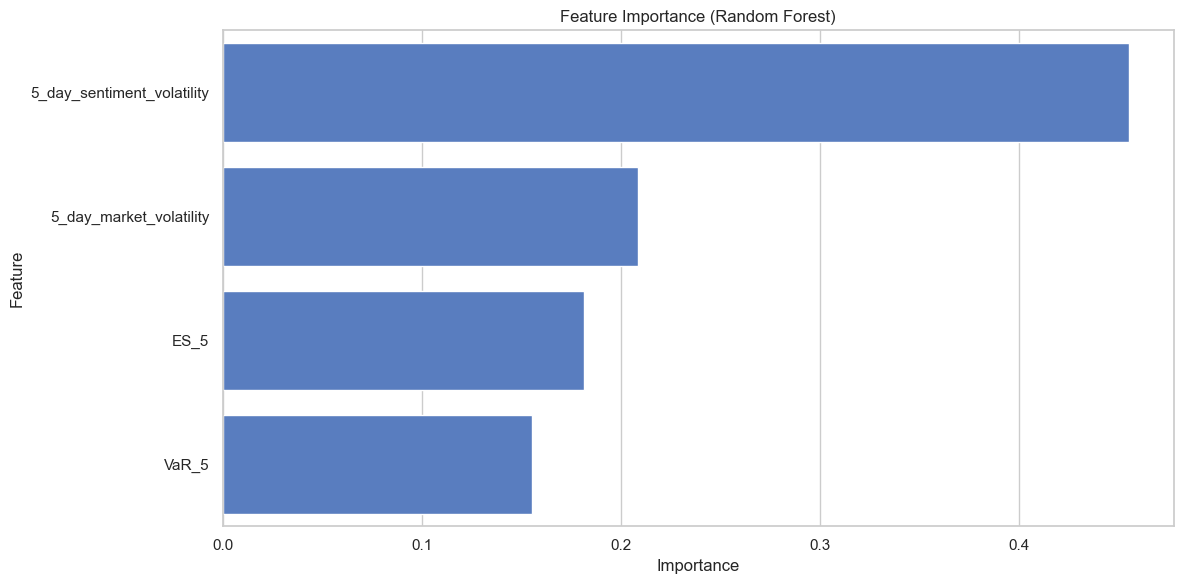

In [248]:
plot_feature_importances(rf_model, X_train)

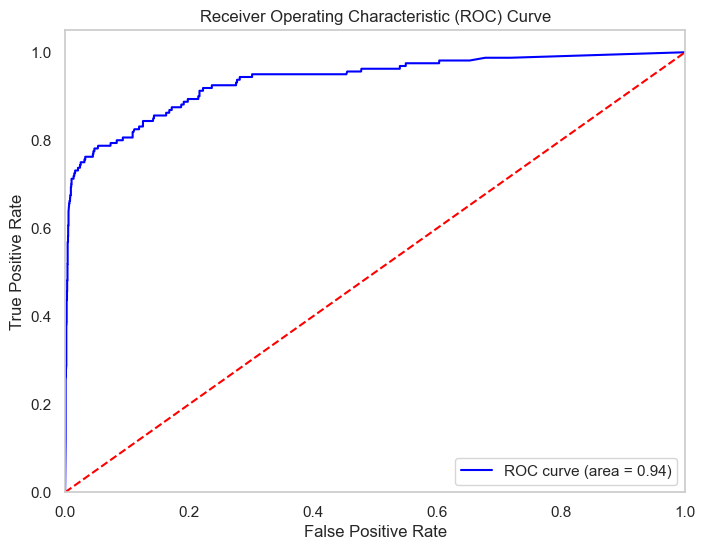

In [249]:
plot_roc_curve(y_test, y_proba)

In [250]:
# Drop NA rows from input features
df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash'])

X_all = df_model[feature_cols]
y_all = df_model['future_crash']
rf_model.fit(X_all, y_all)

# Predict probabilities for every time point
df_model['crash_probability'] = rf_model.predict_proba(X_all)[:, 1]

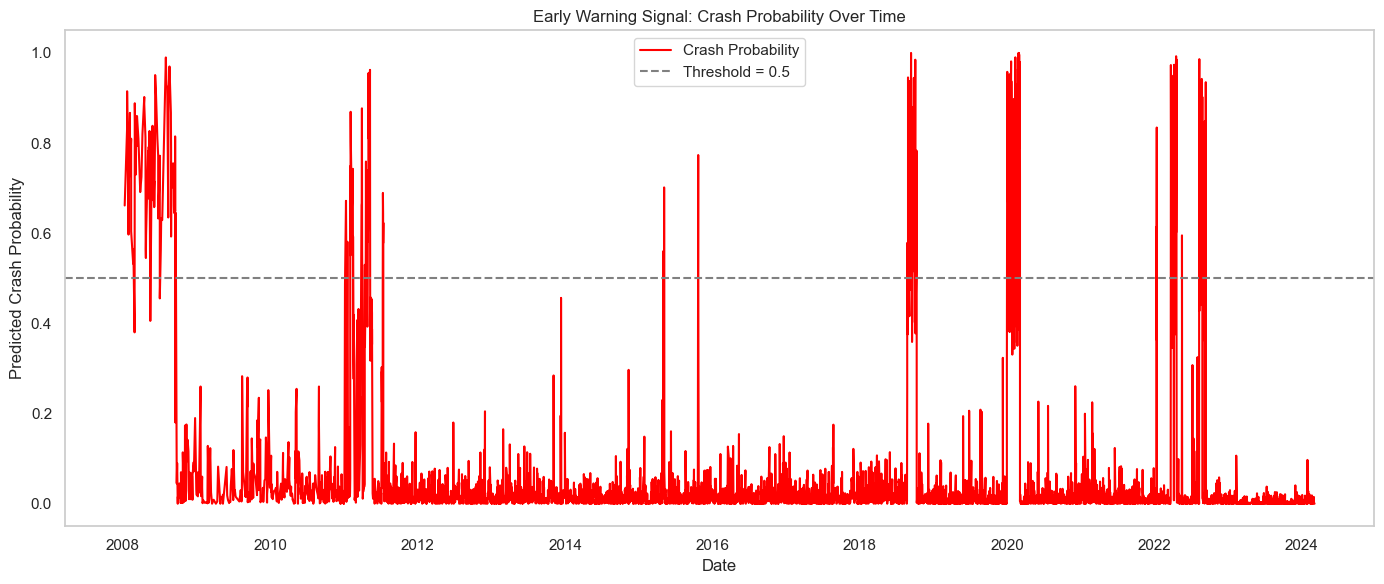

In [251]:
plot_crash_probabilities(df_model, target_col='crash_probability')

### Logit Model

In [252]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state) 
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

logit = LogisticRegression(max_iter=1000, solver='liblinear')  # L1/L2 penalty support
logit.fit(X_resampled, y_resampled)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.97      0.67      0.79      3664
           1       0.06      0.49      0.11       160

    accuracy                           0.66      3824
   macro avg       0.51      0.58      0.45      3824
weighted avg       0.93      0.66      0.76      3824

ROC AUC: 0.6520119746179038


In [253]:
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coefficients)

                      Feature  Coefficient
1  5_day_sentiment_volatility     2.436307
0     5_day_market_volatility     0.236743
3                        ES_5    -0.029906
2                       VaR_5     0.014229


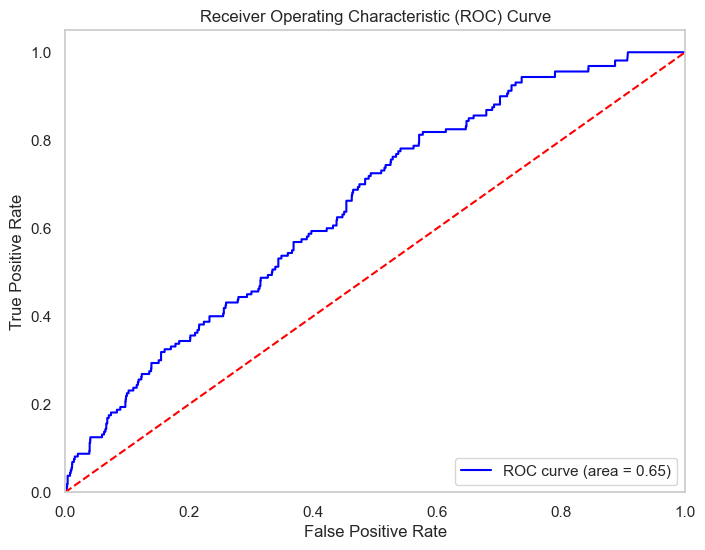

In [254]:
plot_roc_curve(y_test, y_proba)

In [255]:
# Drop NA rows from input features
df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash'])

X_all = df_model[feature_cols]
y_all = df_model['future_crash']

logit = LogisticRegression(max_iter=1000, solver='liblinear')
logit.fit(X_all, y_all)

# Predict probabilities for every time point
df_model['crash_probability'] = logit.predict_proba(X_all)[:, 1]

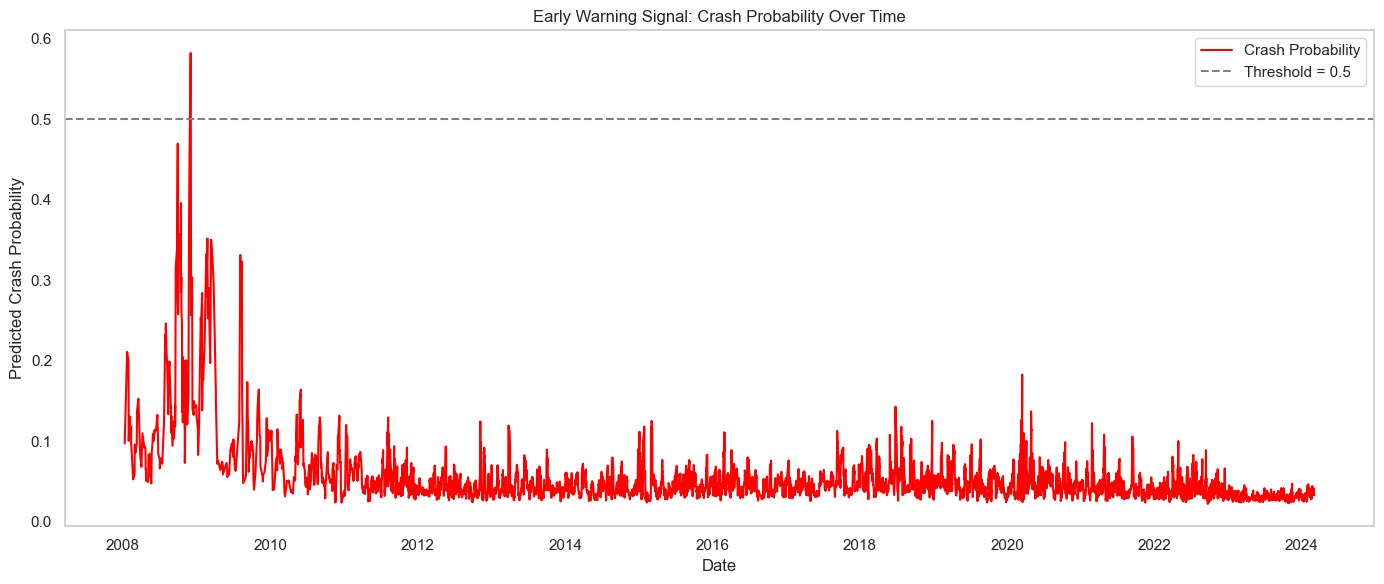

In [256]:
plot_crash_probabilities(df_model, target_col='crash_probability')


### CNN

### LSTM

In [257]:
def create_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X.iloc[i:(i + window)].values)
        ys.append(y.iloc[i + window])  # predict if crash occurs after window
    return np.array(Xs), np.array(ys)

# Use all volatility/sentiment features
features = [col for col in market_sentiment_data.columns if 'volatility' in col]
X_raw = market_sentiment_data[features].fillna(0)
y_raw = market_sentiment_data['future_crash']

# Create sequences
window_size = 22
X_seq, y_seq = create_sequences(X_raw, y_raw, window=window_size)

# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15284, 22, 10), (3821, 22, 10), (15284,), (3821,))

In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.6021 - loss: 0.2199 - val_AUC: 0.2331 - val_loss: 0.2341
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7563 - loss: 0.1808 - val_AUC: 0.1909 - val_loss: 0.2231
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7927 - loss: 0.1672 - val_AUC: 0.5687 - val_loss: 0.2678
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8055 - loss: 0.1661 - val_AUC: 0.6902 - val_loss: 0.1802
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8311 - loss: 0.1556 - val_AUC: 0.5678 - val_loss: 0.3259
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8634 - loss: 0.1433 - val_AUC: 0.5693 - val_loss: 0.3544
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.8705 - loss: 0.1387 - val_AUC: 0.5883 - val_loss: 0.2943
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.9097 - loss: 0.1227 - val_AUC: 0.5603 - val_loss: 0.9800
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AU

In [267]:
from sklearn.metrics import classification_report, roc_auc_score

y_prob = lstm_model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      3821
           1       0.00      0.00      0.00         0

    accuracy                           0.65      3821
   macro avg       0.50      0.33      0.39      3821
weighted avg       1.00      0.65      0.79      3821



In [261]:
crash_prob = lstm_model.predict(X_seq).flatten()
df_model = market_sentiment_data.copy()
df_plot = df_model.iloc[window_size:].copy()
df_plot['crash_probability'] = crash_prob

598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


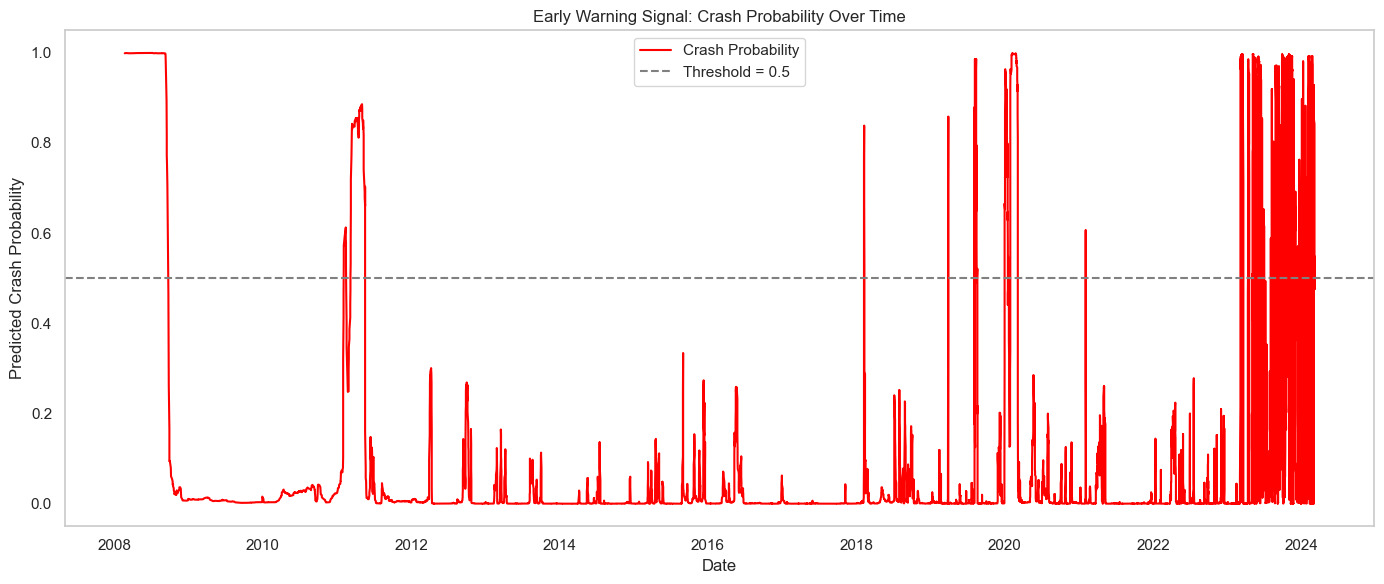

In [262]:
plot_crash_probabilities(df_plot, target_col='crash_probability')

## Early Warning System

In [263]:
# Function for early warning signal
def early_warning_signal(new_data, logit_model, threshold=0.5):
    # Select latest row (most recent date)
    latest_row = new_data[feature_cols].iloc[[-1]]  # 2D array format
    crash_probability = logit_model.predict_proba(latest_row)[0, 1]
    warning_flag = int(crash_probability >= threshold)

    return crash_probability, warning_flag

In [264]:
# # Assume your daily updated data
# warning_results = []

# for i in range(len(market_sentiment_data)):
#     # Slice data up to day i
#     daily_data = market_sentiment_data.iloc[:i+1].copy()

#     # Drop rows with NA so features can be calculated
#     if daily_data[feature_cols].iloc[-1].isna().any():
#         continue

#     # Predict
#     prob, flag = early_warning_signal(daily_data, logit, threshold=0.5)
#     warning_results.append({
#         'Date': daily_data['Date'].iloc[-1],
#         'Crash_Probability': prob,
#         'Warning': flag
#     })

# # Convert to DataFrame
# warnings_df = pd.DataFrame(warning_results)

In [265]:
# plt.figure(figsize=(14, 6))
# plt.plot(warnings_df['Date'], warnings_df['Crash_Probability'], label='Crash Probability', color='red')
# plt.axhline(0.5, linestyle='--', color='gray', label='Threshold = 0.5')
# plt.fill_between(warnings_df['Date'], 0, 1, where=warnings_df['Warning']==1, color='red', alpha=0.1, label='Warning Zone')
# plt.xlabel("Date")
# plt.ylabel("Crash Probability")
# plt.title("Real-Time Early Warning System")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

In [266]:
# latest_window = X_raw.tail(window_size).values.reshape(1, window_size, -1)
# crash_prob_today = model.predict(latest_window)[0][0]

# print(f"Crash Probability Today: {crash_prob_today:.2%}")